## Imports

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import keras
from keras import layers
import random
from keras.utils import to_categorical


## Classes

In [2]:
# CLASSES

class Device:
    def __init__(self, id, ram, storage, cpu, bandwidth, battery, charging):
        self.id = id
        self.ram = ram
        self.storage = storage
        self.cpu = cpu
        self.bandwidth = bandwidth
        self.battery = battery
        self.charging = charging
        self.model: keras.Sequential = Server.create_model()
        self.last_round_participated = 0
        self.data = None  # Placeholder for dataset partition
        self.test_data = None
        self.number_of_times_fitted = 0
        self.hardware_value_sum = 0.0
        
    def lose_battery(self):
        if self.hardware_value_sum > 0.3:
            self.hardware_value_sum -= 0.3
        else:
            self.hardware_value_sum = 0
            print("device turned off!")
        
        # if float(self.battery) > 0.3:
        #     self.battery -= 0.3
        # else:
        #     self.battery = 0
        #     print("device turned off!")

class Server:
    def __init__(self, devices_list: list[Device]):
        self.model: keras.Sequential = Server.create_model()
        self.current_learning_iteration = 0
        self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = []
        self.x_test_global = []
        self.y_test_global = []
        self.devices = devices_list
               
        # The variables below are used to keep track of the remaining rounds and generations and to store the variances
        # They do not logically belong to the Server class
        self.remaining_generation = 0
        self.remaining_round = 0
        self.variances = []  # List to store variances as [round, gen, solution, variance]
        self.pareto_fronts = [] # List to store pareto fronts as [round, gen, solution]

    def evaluate(self, x_test=None, y_test=None, verbose = 0):
        if x_test is None and y_test is None:
            test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
            return test_loss, test_acc
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=verbose)
        return test_loss, test_acc

    def get_weights(self):
        return self.model.get_weights()

    def set_aggregated_weight(self):
        self.model.set_weight(Server.aggregate_weights())

    def give_global_model_weights_to_bitstring_devices(self, bitstring):
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                device.model.set_weights(self.model.get_weights())

    def create_model() -> keras.Sequential:
        model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                        # new
                        loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def aggregate_weights(self, bitstring):
        """Computes the weighted average of model weights from all devices and updates the global model."""
        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        selected_devices = []
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                selected_devices.append(device)

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_participation_ratio = []
        data_lengths = []

        for device in selected_devices:
            # print("*******************")
            # print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.current_learning_iteration)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.current_learning_iteration)
            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))



        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]
        # print(normalized_weights)


        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(selected_devices[d].model.get_weights(), data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))

        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)
        # TODO: Weighted multiplication for each node in each layer of the neural network of the received devices and then summing
        #       the related parts together so that we get a full weighted average of all these devices' models

        # print("Aggregated weights:")
        # for layer_idx, layer_weights in enumerate(aggregated_weights):
            # print(f"Layer {layer_idx}: {layer_weights.shape}")
            
        
        return aggregated_weights




## Functions

In [3]:
# Functions

def fit_bitstring_devices(bitstring, server: Server, epochs=7):
    '''
    server: for using its "current_learning_iteration" variable
    '''

    server.current_learning_iteration += 1
    for device in server.devices:
        if int(bitstring[int(device.id)]) == 1:
            # TODO:
            # makes it so that the selection might choose a device that's been turned off
            # if the device is off, don't fit, use old weights saved on the server.
            # if the device is on, fit, update the weights saved on the server.
            # TODO:
            # COMMENTED FOR NOW, SINCE IT ALREADY AFFECTS NSGA2 EVALUATION
            
            # if device.hardware_value_sum :
            #     continue
            
            device.lose_battery()
            
            device.model.fit(device.data[0], device.data[1], epochs=epochs, verbose=0)
            # print(device.id)
            device.last_round_participated = server.current_learning_iteration
            server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)] = device.model.get_weights()
            device.number_of_times_fitted += 1




def niid_labeldir_split(x_data, y_data, num_clients, beta, seed=None):
    num_classes = 10
    y_indices = np.array([np.argmax(label) for label in y_data])  # From one-hot to class index
    
    rng = np.random.default_rng(seed)  # Local random generator

    # Prepare client partitions
    client_indices = [[] for _ in range(num_clients)]

    for k in range(num_classes):
        idx_k = np.where(y_indices == k)[0]
        rng.shuffle(idx_k)

        # Dirichlet distribution for class k
        proportions = rng.dirichlet(np.repeat(beta, num_clients))

        # Scale proportions to match the number of available samples
        proportions = np.array([int(p * len(idx_k)) for p in proportions])
        # Fix total due to rounding
        while sum(proportions) < len(idx_k):
            proportions[np.argmin(proportions)] += 1
        while sum(proportions) > len(idx_k):
            proportions[np.argmax(proportions)] -= 1

        start = 0
        for i in range(num_clients):
            size = proportions[i]
            client_indices[i].extend(idx_k[start:start + size])
            start += size

    return client_indices



def random_hardware_value_for_devices(devices: list[Device]):
    random_values = [3.91, 0.62, 1.79, 4.96, 5.87, 2.14, 1.41, 5.18, 2.80, 3.00, 0.20, 1.02, 5.73, 0.69, 4.27,
                     5.37, 1.62, 0.93, 3.61, 2.90, 4.53, 2.13, 3.01, 0.07, 1.34, 3.90, 0.28, 1.89, 5.95, 2.76]
    
    for idx in range(len(devices)):
        devices[idx].hardware_value_sum = random_values[idx]
    
    print("Successfully gave each device a random value between 0 and 6 for its hardware objective!")


## Load Data

### Load Devices

In [4]:
# Load dataset from CSV
csv_file = 'devices.csv'
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip().str.lower()

# Convert CSV rows into device objects
devices = []

for _, row in df.iterrows():
    device = Device(
        row['id'], row['ram'], row['storage'], row['cpu'], row['bandwidth'], row['battery'],
        row.get('charging', 0)
    )
    devices.append(device)


# LIMIT TO 30 DEVICES
devices = devices[:30]

random_hardware_value_for_devices(devices)

d:\github project\FL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully gave each device a random value between 0 and 6 for its hardware objective!


### Object Initializations

In [5]:
# Global Model
server = Server(devices_list=devices)
server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = [None for _ in range(len(devices))]

### Split Data Among Devices

In [6]:
SEED = 1
# np.random.seed(SEED)
# np.random.random_integers(1, 10)

In [7]:


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Normalize data and reshape for CNN
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension

x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)  # Add channel dimension

# Shuffle data
# indices = np.arange(len(x_train))
# np.random.shuffle(indices)
# x_train, y_train = x_train[indices], y_train[indices]




# Lower the amount of data for devices
x_train = x_train[:int(len(x_train)/6)] # was 8
y_train = y_train[:int(len(y_train)/6)]




# Correct test split
split_index = int(0.8 * len(x_test))
x_test_devices, y_test_devices = x_test[:split_index], y_test[:split_index]
server.x_test_global, server.y_test_global = x_test[split_index:], y_test[split_index:]

# Training data (for devices)
x_train_devices, y_train_devices = x_train, y_train

# Split training data among devices
beta = 0.5  # lower = more skewed
num_devices = len(devices)
split_indices = niid_labeldir_split(x_train_devices, y_train_devices, num_devices, beta, seed=SEED)

for i, device in enumerate(devices):
    idxs = split_indices[i]

    from sklearn.model_selection import train_test_split

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x_train_devices[idxs], y_train_devices[idxs], test_size=0.3, random_state=42)

    device.data = [X_train, y_train]
    device.test_data = [X_test, y_test]

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)


#TODO:
# how does each objective get better through populations? maybe put em on a scale

X_train shape: (118, 28, 28, 1)
X_test shape: (51, 28, 28, 1)
y_train shape: (118, 10)
y_test shape: (51, 10)
X_train shape: (104, 28, 28, 1)
X_test shape: (45, 28, 28, 1)
y_train shape: (104, 10)
y_test shape: (45, 10)
X_train shape: (151, 28, 28, 1)
X_test shape: (66, 28, 28, 1)
y_train shape: (151, 10)
y_test shape: (66, 10)
X_train shape: (220, 28, 28, 1)
X_test shape: (95, 28, 28, 1)
y_train shape: (220, 10)
y_test shape: (95, 10)
X_train shape: (291, 28, 28, 1)
X_test shape: (125, 28, 28, 1)
y_train shape: (291, 10)
y_test shape: (125, 10)
X_train shape: (182, 28, 28, 1)
X_test shape: (78, 28, 28, 1)
y_train shape: (182, 10)
y_test shape: (78, 10)
X_train shape: (186, 28, 28, 1)
X_test shape: (81, 28, 28, 1)
y_train shape: (186, 10)
y_test shape: (81, 10)
X_train shape: (157, 28, 28, 1)
X_test shape: (68, 28, 28, 1)
y_train shape: (157, 10)
y_test shape: (68, 10)
X_train shape: (357, 28, 28, 1)
X_test shape: (154, 28, 28, 1)
y_train shape: (357, 10)
y_test shape: (154, 10)
X_trai

In [8]:
# test
a, b =devices[23].test_data
print(len(a))

110


### Load Other Data

## First Iteration

In [9]:
# First Iteration
bitstring = [1 for _ in range(len(devices))]
print(bitstring)



# Save weights to a file
# The file name should end in .weights.h5
# The weights can be loaded into a model using model.load_weights('model.weights.h5')
server.model.save_weights('my_model.weights.h5')

# global model sends its weights to all devices
server.give_global_model_weights_to_bitstring_devices(bitstring)



test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.2f}")
print("------------------------------------------------------------")
fit_bitstring_devices(bitstring, server)
server.model.set_weights(server.aggregate_weights(bitstring))
print("------------------------------------------------------------")
test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.2f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0894 - loss: 2.3164
Global Model Accuracy: 0.09
------------------------------------------------------------
device turned off!
device turned off!
device turned off!
------------------------------------------------------------
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5727 - loss: 1.8493
Global Model Accuracy: 0.58


## FL Loop

In [10]:
# Parameters
NUM_ROUNDS = 4 # should be 4

server.remaining_round = NUM_ROUNDS

In [11]:
# DEBUG:
print(server.x_test_global.shape)
print(server.y_test_global.shape)

print(x_train.shape)
print(y_train.shape)

(2000, 28, 28, 1)
(2000, 10)
(10000, 28, 28, 1)
(80, 10)


In [12]:
import random

def generate_binary_list(n: int, percent_ones: float):
    """
    Generate a list of n random binary numbers (0s and 1s),
    where approximately 'percent_ones' fraction are 1s.

    Args:
        n (int): Total number of elements in the list.
        percent_ones (float): Fraction (0.0 to 1.0) indicating what percent should be 1s.

    Returns:
        list[int]: Randomized list of 0s and 1s.
    """
    if not (0 <= percent_ones <= 1):
        raise ValueError("percent_ones must be between 0.0 and 1.0")

    # Determine number of ones
    num_ones = int(round(n * percent_ones))
    num_zeros = n - num_ones

    # Create the list
    binary_list = [1] * num_ones + [0] * num_zeros

    # Shuffle for randomness
    random.shuffle(binary_list)

    return binary_list


In [13]:
lst = generate_binary_list(30, 0.5)
print(lst)
print(lst.count(1))

[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]
15


In [14]:
all_runs_fronts = []  # Stores results across runs
all_runs_solutions = []

VARIANCES = []

needed_values_for_comparison = ""

for i in range(NUM_ROUNDS):
    server.remaining_round = NUM_ROUNDS - i

    # Generate bitstring
    bitstring = generate_binary_list(len(devices), 0.5)
    ###############################
    print(bitstring)
    print(bitstring[0])
    print(type(bitstring[0]))
    # global model sends its weights to all devices
    server.give_global_model_weights_to_bitstring_devices(bitstring)

    test_loss, test_acc = server.evaluate(verbose=0)
    print(f"Global Model Accuracy: {test_acc:.2f}")
    print("------------------------------------------------------------")
    fit_bitstring_devices(bitstring, server)
    server.model.set_weights(server.aggregate_weights(bitstring))
    print("------------------------------------------------------------")
    test_loss, test_acc = server.evaluate(verbose=0)
    print(f"Global Model Accuracy: {test_acc:.2f}")
    
    # ---
    
    accuracies = []

    for device in server.devices:
        x_test = device.test_data[0]
        y_test = device.test_data[1]
        
        loss, accuracy = server.evaluate(x_test, y_test)
        
        accuracies.append(round(accuracy, 2))
        print(f"Device {device.id} Accuracy: {round(accuracy, 2)}")

    VARIANCE = np.var(accuracies)
    VARIANCE_SCORE = 1.0/VARIANCE
    MEAN = np.mean(accuracies)
    STANDARD_DEVIATION = np.std(accuracies)
    FAIRNESS = 1.0/STANDARD_DEVIATION
    
    needed_values_for_comparison += f"Round: {i+1}\nServer Test Accuracy: {test_acc}\nVariance: {VARIANCE}\nVariance Score: {VARIANCE_SCORE}\nMean: {MEAN}\nStandard Deviation: {STANDARD_DEVIATION}\nFairness: {FAIRNESS}\n---\n"

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1]
1
<class 'int'>
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5727 - loss: 1.8493
Global Model Accuracy: 0.58
------------------------------------------------------------
device turned off!
------------------------------------------------------------
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7755 - loss: 1.1100
Global Model Accuracy: 0.76
Device 0.0 Accuracy: 0.33
Device 1.0 Accuracy: 0.51
Device 2.0 Accuracy: 0.85
Device 3.0 Accuracy: 0.72
Device 4.0 Accuracy: 0.78
Device 5.0 Accuracy: 0.82
Device 6.0 Accuracy: 0.79
Device 7.0 Accuracy: 0.84
Device 8.0 Accuracy: 0.85
Device 9.0 Accuracy: 0.58
Device 10.0 Accuracy: 0.83
Device 11.0 Accuracy: 0.79
Device 12.0 Accuracy: 0.75
Device 13.0 Accuracy: 0.86
Device 14.0 Accuracy: 0.66
Device 15.0 Accuracy: 0.78
Device 16.0 Accuracy: 0.82
Device 17.0 Accuracy: 0.82
Device 18.0 Accuracy: 0.65
Device 19.0 Accuracy: 0.62
Device 20.0 Accurac

In [15]:
print(server.evaluate())

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8995 - loss: 0.4142
(0.46843335032463074, 0.8790000081062317)


In [16]:
accuracies = []

for device in server.devices:
    x_test = device.test_data[0]
    y_test = device.test_data[1]
    
    loss, accuracy = server.evaluate(x_test, y_test)
    
    accuracies.append(round(accuracy, 2))
    print(f"Device {device.id} Accuracy: {round(accuracy, 2)}")

VARIANCE = np.var(accuracies)
VARIANCE_SCORE = 1.0/VARIANCE
MEAN = np.mean(accuracies)
STANDARD_DEVIATION = np.std(accuracies)

Device 0.0 Accuracy: 0.73
Device 1.0 Accuracy: 0.71
Device 2.0 Accuracy: 0.92
Device 3.0 Accuracy: 0.82
Device 4.0 Accuracy: 0.9
Device 5.0 Accuracy: 0.87
Device 6.0 Accuracy: 0.88
Device 7.0 Accuracy: 0.9
Device 8.0 Accuracy: 0.92
Device 9.0 Accuracy: 0.75
Device 10.0 Accuracy: 0.89
Device 11.0 Accuracy: 0.88
Device 12.0 Accuracy: 0.77
Device 13.0 Accuracy: 0.91
Device 14.0 Accuracy: 0.76
Device 15.0 Accuracy: 0.85
Device 16.0 Accuracy: 0.95
Device 17.0 Accuracy: 0.95
Device 18.0 Accuracy: 0.8
Device 19.0 Accuracy: 0.83
Device 20.0 Accuracy: 0.77
Device 21.0 Accuracy: 0.85
Device 22.0 Accuracy: 0.89
Device 23.0 Accuracy: 0.8
Device 24.0 Accuracy: 0.84
Device 25.0 Accuracy: 0.86
Device 26.0 Accuracy: 0.82
Device 27.0 Accuracy: 0.93
Device 28.0 Accuracy: 0.68
Device 29.0 Accuracy: 0.89


In [17]:
print(f"MEAN: {MEAN}")
print(f"VARIANCE: {VARIANCE}")
print(f"STANDARD_DEVIATION: {STANDARD_DEVIATION}")
print(f"Fairness: {1.0/STANDARD_DEVIATION}")

MEAN: 0.844
VARIANCE: 0.005064
STANDARD_DEVIATION: 0.07116178749862878
Fairness: 14.052485682983567


In [18]:
print(needed_values_for_comparison)

Round: 1
Server Test Accuracy: 0.7580000162124634
Variance: 0.01699733333333333
Variance Score: 58.83275807969879
Mean: 0.734
Standard Deviation: 0.13037382150314275
Fairness: 7.670251500420231
---
Round: 2
Server Test Accuracy: 0.8485000133514404
Variance: 0.005682222222222222
Variance Score: 175.98748533437623
Mean: 0.8166666666666668
Standard Deviation: 0.07538051619763705
Fairness: 13.26602748882936
---
Round: 3
Server Test Accuracy: 0.8535000085830688
Variance: 0.0070826666666666685
Variance Score: 141.18975903614455
Mean: 0.818
Standard Deviation: 0.08415858046965068
Fairness: 11.88232969733396
---
Round: 4
Server Test Accuracy: 0.8790000081062317
Variance: 0.005064
Variance Score: 197.47235387045814
Mean: 0.844
Standard Deviation: 0.07116178749862878
Fairness: 14.052485682983567
---



In [19]:
accuracy_plot_x = []
accuracy_plot_y = []

for item in needed_values_for_comparison.split("---")[:-1]:
    for subitem in item.split("\n"):
        if "Server Test Accuracy" in subitem:
            print(float(subitem[subitem.find(": ")+2:]))
            accuracy_plot_y.append(float(subitem[subitem.find(": ")+2:]))
        
    accuracy_plot_x.append(needed_values_for_comparison.split("---").index(item)+1)
        
print(accuracy_plot_x)
print(accuracy_plot_y)

0.7580000162124634
0.8485000133514404
0.8535000085830688
0.8790000081062317
[1, 2, 3, 4]
[0.7580000162124634, 0.8485000133514404, 0.8535000085830688, 0.8790000081062317]


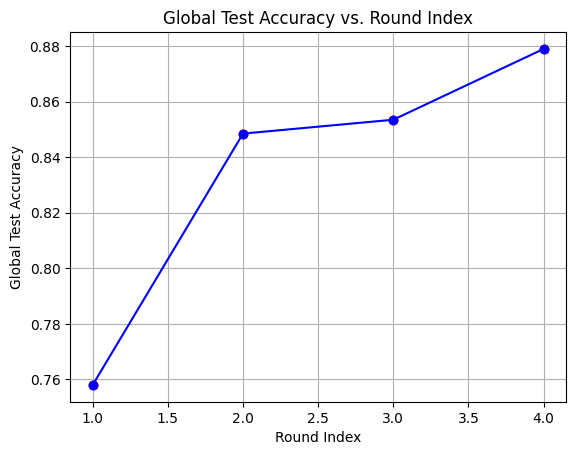

In [20]:
import matplotlib.pyplot as plt

# Example points (replace with your own x and y values)
x = accuracy_plot_x
y = accuracy_plot_y

# Scatter plot of points
plt.scatter(x, y, color='red', zorder=2)

# Plot line with markers
plt.plot(x, y, marker='o', linestyle='-', color='blue')

# Highlight the points explicitly if you like
plt.scatter(x, y, color='red')

plt.xlabel("Round Index")
plt.ylabel("Global Test Accuracy")
plt.title("Global Test Accuracy vs. Round Index")
plt.grid(True)
plt.show()
